# PREDICTION OF SS AND DETECT MOST IMPORTANT FEATURES 

# Prepare the data 

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

severity_train = pd.read_csv("train_handmade.csv")
severity_test = pd.read_csv("test_handmade.csv")

In [2]:
trainSize = severity_train.shape[0]
#severity_train["severity score"] = severity_train["severity score"].apply(np.log)
print(severity_test.shape)
print(severity_train.shape)

(10, 10)
(14, 11)


In [3]:
train_names = severity_train["name"]
test_names = severity_test["name"]

severity_test.drop("name", axis=1, inplace=True)
severity_train.drop("name", axis=1, inplace=True)

# (We dont ignore the na or missing in train data) 

In [4]:
import numpy as np
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor #as gbr as rfr

from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [5]:
rs_const = 80 #always use the same one value for all model tuning process
test_ratio_const = 0.2 
train_data   = severity_train.drop("severity score", axis=1)
train_target = severity_train[['severity score']]
test_data    = severity_test

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target,\
                                                    test_size=test_ratio_const, random_state=rs_const)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

In [7]:
# 1. linear regression:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

RMSE train: 2.6101512668808386e-15
RMSE test : 1.2560739669470201e-15


In [8]:
# 2. ridge
grid_param = [{'alpha': np.logspace(-4, 4, 20)}]

gs = GridSearchCV(estimator=linear_model.Ridge(random_state=rs_const), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

Best params: {'alpha': 0.615848211066026}
Best score : -8.136055545727519
RMSE train: 0.1341723249209698
RMSE test : 0.5478442937375102


In [9]:
pd.Series(model.coef_.flatten()).describe()

count    9.000000
mean     0.031621
std      0.426037
min     -0.545954
25%     -0.212771
50%     -0.069826
75%      0.095255
max      0.969999
dtype: float64

In [10]:
# 3. lasso 
# max_iter = 1000, if not enough better increase alpha to proceed, 
# but not increase max_iter, as it mostly won't help much on the slow convergence. 
grid_param = [{'alpha': np.logspace(-3, 4, 20)}] 

gs = GridSearchCV(estimator=linear_model.Lasso(random_state=rs_const, normalize=False), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

Best params: {'alpha': 0.00545559478116852}
Best score : 0.9949650419514396
RMSE train: 0.009175952971943511
RMSE test : 0.03034517740131999


In [11]:
sum(model.coef_ > 1e-6) / model.coef_.shape[0]


0.2222222222222222

In [12]:
# 4. ElasticNet
grid_param = [{'alpha': np.logspace(-2, 4, 20), 'l1_ratio': np.linspace(0.015, 1, 20)}]

# Confirmed that setting scoring='neg_mean_squared_error' is the same result as using the default "R2" score.
gs = GridSearchCV(estimator=linear_model.ElasticNet(random_state=rs_const), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))


Best params: {'alpha': 0.01, 'l1_ratio': 1.0}
Best score : 0.9840125898258085
RMSE train: 0.016456029625856083
RMSE test : 0.05314327793847199


In [13]:
sum(model.coef_ > 1e-6) / model.coef_.shape[0]


0.2222222222222222

In [14]:

grid_param = [{}]

# Step
#learning_rate:0.1 -> 0.05 -> 0.01 -> 0.005 ->... 0.005 best
#n_estimators: 140 -> 280  -> 1000 -> 2000  ->... 3000 best

gs = GridSearchCV(estimator = GradientBoostingRegressor(\
                                    learning_rate=0.005,\
                                    n_estimators=3000,\
                                    max_depth=5,\
                                    min_samples_split=7,\
                                    min_samples_leaf=1,\
                                    max_features='sqrt',\
                                    subsample=0.88,\
                                    random_state=rs_const), \
                                    param_grid = grid_param,\
                                    n_jobs=4, cv=5)  

gs.fit(X_train, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

Best params: {}
Best score : -21.3401513209596
RMSE train: 0.0029853347957291
RMSE test : 1.1254785994044234


In [15]:
model = GradientBoostingRegressor(\
                                    learning_rate=0.005,\
                                    n_estimators=1000,\
                                    max_depth=5,\
                                    min_samples_split=7,\
                                    min_samples_leaf=1,\
                                    max_features='sqrt',\
                                    subsample=0.88,\
                                    random_state=rs_const)
model.fit(X_train, y_train)

print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

RMSE train: 0.08504583084842417
RMSE test : 1.1331683977912297


In [16]:
print('sqrt total feature: {}'.format(math.sqrt(X_train.columns.shape[0])))
print('40% of total feature: {}'.format(X_train.columns.shape[0] * 0.4))

sqrt total feature: 3.0
40% of total feature: 3.6


<AxesSubplot:xlabel='feature_importance', ylabel='index'>

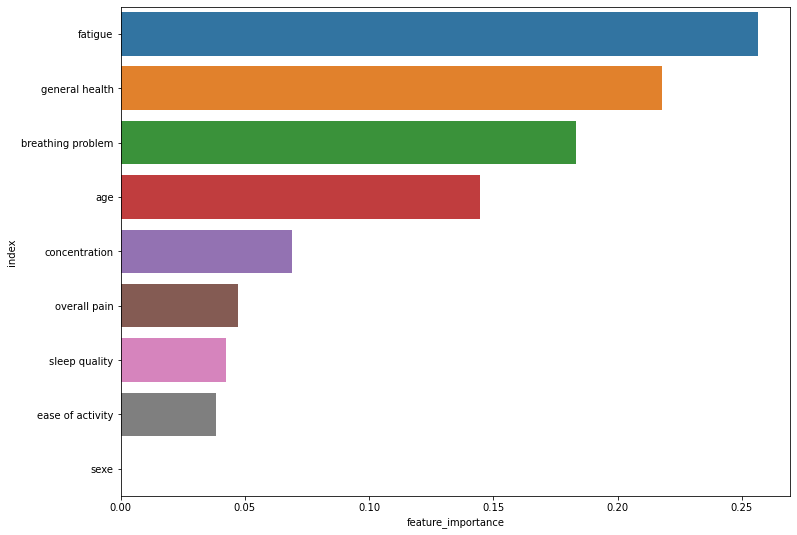

In [17]:
varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)


In [18]:
grid_param = [{}]

gs = GridSearchCV(estimator = RandomForestRegressor(\
                                    max_features=9,\
                                    n_estimators=200,\
                                    min_samples_split=5,\
                                    min_samples_leaf=1,\
                                    random_state=rs_const,\
                                    n_jobs=-1),\
                  param_grid = grid_param, n_jobs=-1, cv=5)  

gs.fit(X_train, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))


Best params: {}
Best score : -39.426030053451264
RMSE train: 0.8189613332178401
RMSE test : 1.2096845192684098


In [19]:
display(model)


RandomForestRegressor(max_features=9, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=80)

<AxesSubplot:xlabel='feature_importance', ylabel='index'>

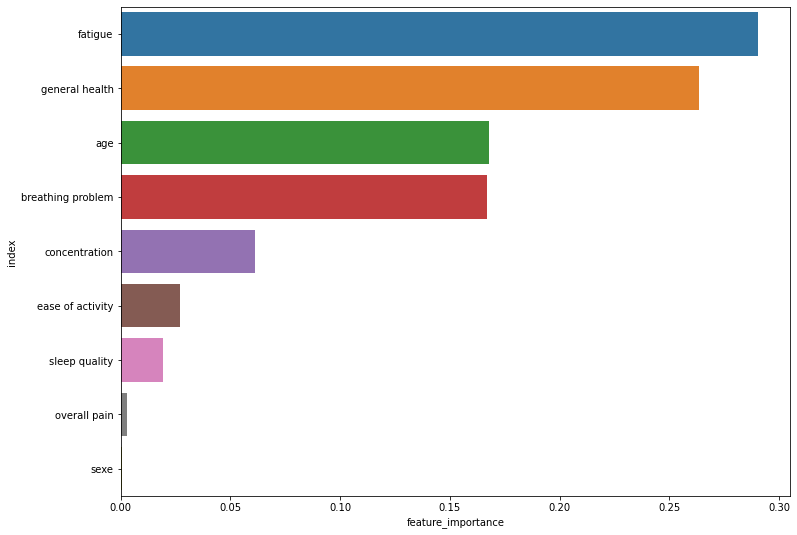

In [20]:
varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)


RMSE train: 0.8203590292815929
RMSE test : 1.23241356216712


<AxesSubplot:xlabel='feature_importance', ylabel='index'>

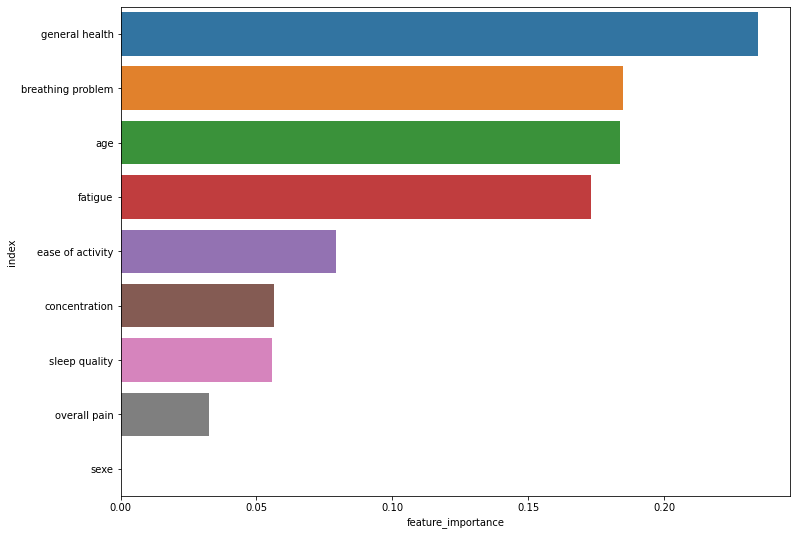

In [21]:
# RF best/try:
model = RandomForestRegressor(\
            max_features=3,\
            n_estimators=200,\
            min_samples_split=5,\
            min_samples_leaf=1,\
            random_state=rs_const,\
            n_jobs=-1)

model.fit(X_train, y_train)
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:9,], ax = ax)

In [22]:
# best multi model stacking: 
models = [
    # linear model
    #linear_model.Lasso(alpha=0.00545559478116852, random_state=rs_const),
    linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const),
 
    # conservative random forst model
#     RandomForestRegressor(\
#                         max_depth=5,\
#                         max_features='sqrt',\
#                         n_estimators=1000,\
#                         random_state=rs_const,\
#                         n_jobs=-1),
    
    RandomForestRegressor(\
                        max_features=70,\
                        n_estimators=200,\
                        min_samples_split=5,\
                        min_samples_leaf=1,\
                        random_state=rs_const,\
                        n_jobs=-1),
#     RandomForestRegressor(\
#                         max_depth=None,\
#                         max_features=80,\
#                         n_estimators=170,\
#                         random_state=rs_const,\
#                         n_jobs=-1),
    
    # conservative gbm model
#     GradientBoostingRegressor(\
#                         learning_rate=0.005,\
#                         n_estimators=3000,\
#                         max_depth=2,\
#                         min_samples_split=40,\
#                         min_samples_leaf=10,\
#                         max_features=120,\
#                         subsample=0.8,\
#                         random_state=rs_const),
    
    GradientBoostingRegressor(\
                        learning_rate=0.005,\
                        n_estimators=3000,\
                        max_depth=5,\
                        min_samples_split=7,\
                        min_samples_leaf=1,\
                        max_features='sqrt',\
                        subsample=0.8,\
                        random_state=rs_const)
    
#     GradientBoostingRegressor(\
#                         learning_rate=0.01,\
#                         n_estimators=2000,\
#                         max_depth=5,\
#                         min_samples_split=28,\
#                         min_samples_leaf=3,\
#                         max_features=63,\
#                         subsample=0.8,\
#                         random_state=rs_const)
    ]

meta_model = linear_model.LinearRegression(normalize=False) # normalize=True: almost the same

In [23]:
%%time 
# Single model selection: best Lasso:
model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const)

model.fit(X_train_std, y_train)

final_train_prediction = model.predict(X_train_std)
final_test_prediction  = model.predict(X_test_std)

print("For log severity score: ")
print("RMSE train: {}".format(rmse(y_train, final_train_prediction)))
print("RMSE test : {}".format(rmse(y_test,  final_test_prediction)))
print("")
print("For actual severity score: ")
print("RMSE train: {}".format(rmse(np.expm1(y_train), np.expm1(final_train_prediction))))
print("RMSE test : {}".format(rmse(np.expm1(y_test),  np.expm1(final_test_prediction))))

For log severity score: 
RMSE train: 0.016456029625856083
RMSE test : 0.05314327793847199

For actual severity score: 
RMSE train: 55.44809599424817
RMSE test : 5.687843258359278
Wall time: 9.05 ms


In [24]:
scaler = StandardScaler()
scaler.fit(train_data)

train_data_std = scaler.transform(train_data)
test_data_std  = scaler.transform(test_data)

In [25]:
model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const)

In [29]:
model = linear_model.ElasticNet(alpha=0.01, l1_ratio=1.0, random_state=rs_const)
#model = linear_model.ElasticNet(alpha=0.01, l1_ratio=0.015, random_state=rs_const)

model.fit(train_data_std, train_target)

final_train_prediction = model.predict(train_data_std)
final_test_prediction  = model.predict(test_data_std)

print("For log severity score: ")
print("RMSE train: {}".format(rmse(train_target, final_train_prediction)))
print("")
print("For actual severity score: ")
print("RMSE train: {}".format(rmse(np.expm1(train_target), np.expm1(final_train_prediction))))

For log severity score: 
RMSE train: 0.013219639611316072

For actual severity score: 
RMSE train: 44.412384058338915


In [30]:
#final_test_prediction = np.expm1(final_test_prediction)

final_submission = pd.DataFrame()
final_submission['severity score'] = final_test_prediction


In [31]:
final_submission

,severity score
0,6.387363
1,5.675805
2,5.402053
3,2.521333
4,8.032106
5,6.624454
6,6.291354
7,5.014510
8,5.066560
9,2.648724


# What we obtain with the formula:

50%(fatigue)+15%(10–mood) + 15%(10–ease of activity) + 20%(10–general health)

MOOD IS CHANGED BY SLEEP QUALITY IN THE CALCUL OF THE FORMULA FOR THE MOMENT 

    severity score:     
0 : 6.4 \
1 : 5.7 \
2 : 5.4\
3 : 2.5\
4 : 8.05\
5 : 6.65 \
6 : 6.3 \
7 : 5.05\
8 : 5.05\
9 : 2.65 